In [404]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from influxdb import DataFrameClient
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, make_scorer
from sklearn2pmml import make_pmml_pipeline, sklearn2pmml
import requests

# Get data from influxDB

In [365]:
client = DataFrameClient(host='193.196.37.63', port=8086)

In [366]:
client.get_list_database()

[{'name': '_internal'}, {'name': 'db0'}]

In [367]:
client.switch_database('db0')

In [368]:
result = client.query('SELECT * FROM orientation')

In [369]:
sensor_data = result['orientation']

# Data Understanding

In [370]:
sensor_data.head()

,alpha,beta,count,gamma,label,subject
2019-08-03 15:48:37.109000+00:00,51549,97988,1,-1155,jogging,13e5e
2019-08-03 15:48:37.157000+00:00,59931,97514,2,-1168,jogging,13e5e
2019-08-03 15:48:37.209000+00:00,70213,96926,3,-1184,jogging,13e5e
2019-08-03 15:48:37.257000+00:00,72956,96765,4,-1188,jogging,13e5e
2019-08-03 15:48:37.309000+00:00,75052,96642,5,-1191,jogging,13e5e


In [371]:
sensor_data = sensor_data.drop(columns = ['count'])

In [372]:
sensor_data.describe()

,alpha,beta,gamma
count,932.000000,932.000000,932.000000
mean,84034.189914,85126.819742,-5203.306867
std,18039.062191,9643.366210,10817.611813
min,41540.000000,49497.000000,-50805.000000
25%,69215.750000,77426.000000,-8398.000000
50%,85387.000000,84824.000000,-4206.000000
75%,100120.500000,93623.250000,-755.000000
max,120449.000000,109120.000000,28708.000000


In [373]:
sensor_data.shape

(932, 5)

In [374]:
type(sensor_data.index)

pandas.core.indexes.datetimes.DatetimeIndex

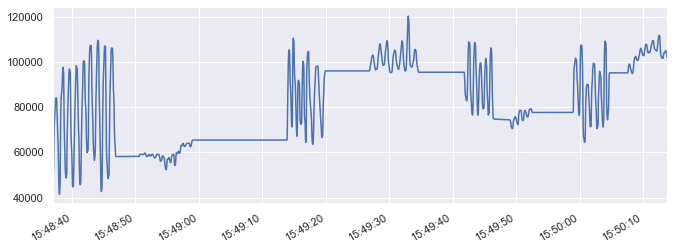

In [377]:
sns.set(rc={'figure.figsize':(11, 4)})

sensor_data['alpha'].plot()

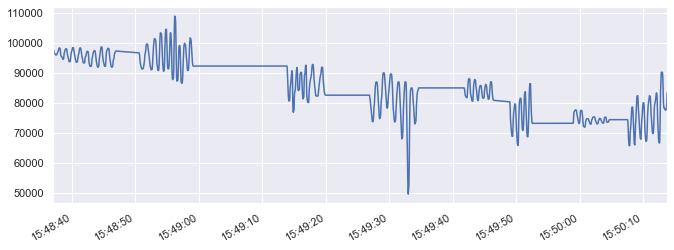

In [378]:
sensor_data['beta'].plot()

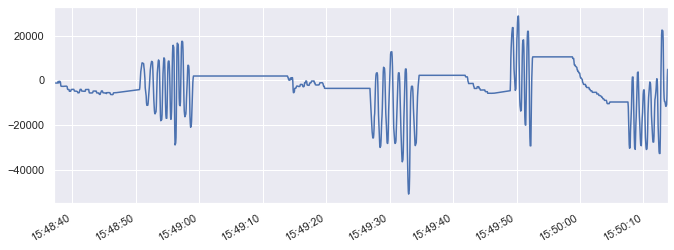

In [380]:
sensor_data['gamma'].plot()

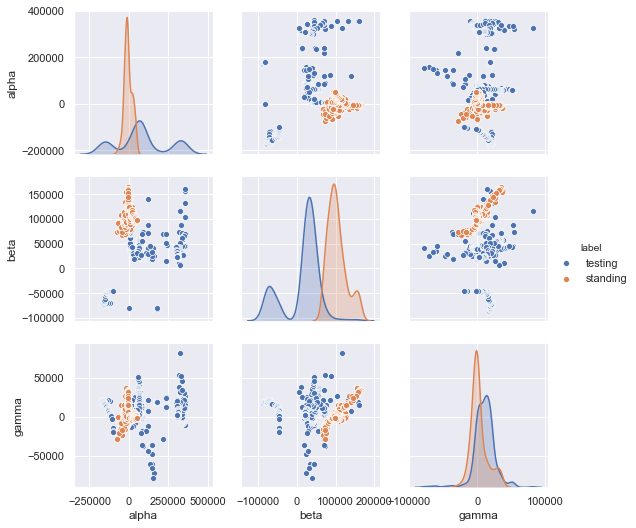

In [381]:
sns.pairplot(df, hue='label')

# Feature Engineering

In [382]:
sensor_data_X = sensor_data.drop(columns=['label'])
sensor_data_y = sensor_data[['label']]

In [383]:
# transforming 3 features into 3 PCs ??
pca = PCA(n_components=3)
pca.fit(sensor_data_X.drop(columns=['subject']))
pca.explained_variance_ratio_

array([0.71989024, 0.18136995, 0.09873981])

# Model Training

In [245]:
# Leave-one-subject-out Cross Validation

# an iterable yielding (train, test) splits as arrays of indices.
# cv_subject_indices = [(sensor_data_X[sensor_data_X['subject'] != subject].index, sensor_data_X[sensor_data_X['subject'] == subject].index) for subject in sensor_data.subject.unique()]


In [419]:
# this is actually a leave-one-subject-out implementation
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
logo = LeaveOneGroupOut()
cv_subject_indices = [(train_index, test_index) for train_index, test_index in logo.split(X=sensor_data_X, y=sensor_data_y, groups=sensor_data_X['subject'])]


In [420]:
from sklearn.model_selection import cross_validate
clf = SVC(gamma='auto')
cv_results = cross_validate(estimator=clf, X=sensor_data_X.drop(columns=['subject']), y=sensor_data_y.values.ravel(), scoring=make_scorer(f1_score, pos_label='jogging'), cv=cv_subject_indices)


In [411]:
cv_results

{'fit_time': array([0.01259208, 0.01216507, 0.01624703, 0.01290083]),
 'score_time': array([0.00665617, 0.00508881, 0.00340819, 0.00479293]),
 'test_score': array([0.        , 0.60773481, 0.        , 0.62091503])}

In [412]:
# same amount of test scores as subjects - makes sense :)
sensor_data.subject.unique()

array(['13e5e', '14e5e', '15e5e', '16e5e'], dtype=object)

In [417]:
loo = LeaveOneOut()
cv_subject_indices = [(train_index, test_index) for train_index, test_index in loo.split(X=sensor_data_X, y=sensor_data_y, groups=sensor_data_X['subject'])]
clf = SVC(gamma='auto')
cv_results = cross_validate(estimator=clf, X=sensor_data_X.drop(columns=['subject']), y=sensor_data_y.values.ravel(), cv=cv_subject_indices)

cv_results


{'fit_time': array([0.0199821 , 0.01909828, 0.01801515, 0.01789403, 0.01938891,
        0.01828909, 0.0184958 , 0.01781297, 0.01915908, 0.01965117,
        0.01959991, 0.01817298, 0.01879811, 0.01792908, 0.0184021 ,
        0.0187819 , 0.0183742 , 0.01817608, 0.01950598, 0.01798201,
        0.01799488, 0.01794887, 0.01768279, 0.01815104, 0.01793122,
        0.01774073, 0.01996493, 0.01827288, 0.01753616, 0.01820898,
        0.0183661 , 0.01852798, 0.01832914, 0.01827192, 0.01816893,
        0.01748514, 0.01848674, 0.01823902, 0.01863909, 0.01785517,
        0.01737499, 0.02029395, 0.01823711, 0.01751494, 0.01758575,
        0.0181036 , 0.01995301, 0.01823163, 0.01998997, 0.01941395,
        0.01777983, 0.0176909 , 0.01769209, 0.01791191, 0.01807308,
        0.01738501, 0.01741385, 0.01845694, 0.01946998, 0.01870894,
        0.0178299 , 0.01791286, 0.01813412, 0.01824403, 0.01769519,
        0.01764703, 0.01765203, 0.01802397, 0.01762676, 0.01806903,
        0.01786804, 0.01840997, 0.01

In [427]:
# Recursive Feature Elimination
# https://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.feature_selection import RFECV
clf = SVC(kernel="linear")
rfecv = RFECV(clf, step=1, cv=cv_subject_indices, n_jobs=-1)

In [428]:
rfecv.fit(X=sensor_data_X.drop(columns=['subject']), y=sensor_data_y.values.ravel())

RFECV(cv=[(array([319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
       345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
       371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383,
       384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396,
       397, 398, 399, 400, 401,...
       916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928,
       929, 930, 931]))],
      estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                    decision_function_shape='ovr', degree=3,
                    gamma='auto_deprecated', kernel='linear', max_iter=-1,
                    probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=-1, scoring=None, step=1, verbose=0)

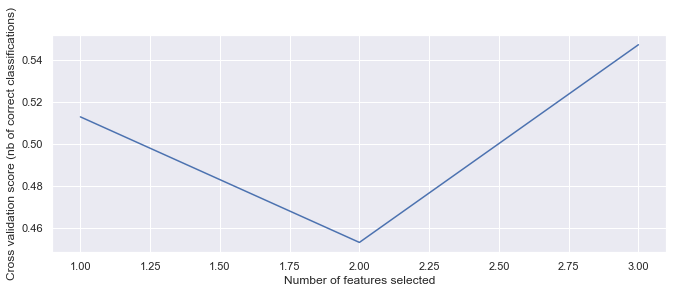

In [430]:
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [85]:
pl = Pipeline([('clf', SVC())])


In [86]:
pl.fit(X_train, y_train)

/Users/Marius/Programs/Classification/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Marius/Programs/Classification/venv/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

# Model Evaluation

In [87]:
confusion_matrix(pl.predict(X_test), y_test)

array([[  2,   0],
       [ 68, 186]])

In [96]:
f1_score(pl.predict(X_test), y_test, pos_label='testing')

0.8454545454545455

# Deployment

In [94]:
sklearn2pmml(make_pmml_pipeline(pl), 'LogisticRegressionModel.pmml', with_repr=True)

The pmml file is now (via ssh) uploaded to the machine and then loaded into the running openscoring server (it needs to be uploaded first to work around hhtp cross origin settings that would be needed when making the request from another machine)
> curl -X PUT --data-binary @LogisticRegressionModel.pmml -H "Content-type: text/xml" http://localhost:8080/openscoring/model/LogisticRegression


In [159]:
# Test the REST endpoint (the endpoint is actually called by the JS of the WebApp)
url = 'http://193.196.37.63:8080/openscoring/model/LogisticRegression'
data = {
  "id": "record--01", 
  "arguments": {
  "x1": int(X_test.iloc[1])
  }
}

response = requests.post(url, json=data)
response.json()['result']['y']

'testing'

In [164]:
# TODO DELETE
# check whether local clf predicts the same as the endpoint returns
for i in len(X_test):
    print(i)
    print('Lokal: ', pl.predict(X_test.iloc[i:i+1]))
    
    data = {
        "id": "record--01", 
        "arguments": {
            "x1": int(X_test.iloc[i])
        }
    }

    response = requests.post(url, json=data)
    print('Server:', response.json()['result']['y'])

0
Lokal:  ['testing']
Server: testing
1
Lokal:  ['testing']
Server: testing
2
Lokal:  ['testing']
Server: testing
3
Lokal:  ['testing']
Server: testing
4
Lokal:  ['testing']
Server: testing
5
Lokal:  ['testing']
Server: testing
6
Lokal:  ['testing']
Server: testing
7
Lokal:  ['testing']
Server: testing
8
Lokal:  ['testing']
Server: testing
9
Lokal:  ['testing']
Server: testing
10
Lokal:  ['testing']
Server: testing
11
Lokal:  ['testing']
Server: testing
12
Lokal:  ['testing']
Server: testing
13
Lokal:  ['testing']
Server: testing
14
Lokal:  ['testing']
Server: testing
15
Lokal:  ['testing']
Server: testing
16
Lokal:  ['testing']
Server: testing
17
Lokal:  ['testing']
Server: testing
18
Lokal:  ['testing']
Server: testing
19
Lokal:  ['testing']
Server: testing
20
Lokal:  ['testing']
Server: testing
21
Lokal:  ['testing']
Server: testing
22
Lokal:  ['testing']
Server: testing
23
Lokal:  ['testing']
Server: testing
24
Lokal:  ['testing']
Server: testing
25
Lokal:  ['testing']
Server: test

Server: testing
209
Lokal:  ['testing']
Server: testing
210
Lokal:  ['testing']
Server: testing
211
Lokal:  ['testing']
Server: testing
212
Lokal:  ['testing']
Server: testing
213
Lokal:  ['testing']
Server: testing
214
Lokal:  ['testing']
Server: testing
215
Lokal:  ['testing']
Server: testing
216
Lokal:  ['testing']
Server: testing
217
Lokal:  ['testing']
Server: testing
218
Lokal:  ['testing']
Server: testing
219
Lokal:  ['testing']
Server: testing
220
Lokal:  ['testing']
Server: testing
221
Lokal:  ['testing']
Server: testing
222
Lokal:  ['testing']
Server: testing
223
Lokal:  ['testing']
Server: testing
224
Lokal:  ['testing']
Server: testing
225
Lokal:  ['testing']
Server: testing
226
Lokal:  ['testing']
Server: testing
227
Lokal:  ['testing']
Server: testing
228
Lokal:  ['testing']
Server: testing
229
Lokal:  ['testing']
Server: testing
230
Lokal:  ['testing']
Server: testing
231
Lokal:  ['testing']
Server: testing
232
Lokal:  ['testing']
Server: testing
233
Lokal:  ['testing']


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.